In [214]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
import pickle
import os
from datetime import datetime
import json
import tensorflow as tf
from matplotlib.pyplot import imshow

# Reading the photos

In [2]:
os.getcwd() 

'C:\\Users\\CSH\\Desktop\\투빅스 프로젝트 2'

In [3]:
image_dir = 'C:\\Users\\CSH\\Desktop\\투빅스 프로젝트 2/train/'

In [4]:
for path, dir, files in os.walk(image_dir):
    print(path)
    print(dir)
    print(files) # 이렇게다 파일들로 들어가서 그안의 목록들까지 보는구나 

C:\Users\CSH\Desktop\투빅스 프로젝트 2/train/
[]
['000000000139.jpg', '000000000285.jpg', '000000000632.jpg', '000000000724.jpg', '000000000776.jpg', '000000000785.jpg', '000000000802.jpg', '000000000872.jpg', '000000000885.jpg', '000000001000.jpg']


In [5]:
train_x = []
resizing = (32, 32)

for path, dir, files in os.walk(image_dir):
    for file in files:
        image_dir = path + '/' + file 
        img = Image.open(image_dir)
        img = img.resize(resizing)
        if not img.format == "RGB": # 이미지의 포맷이 RGB가 아닐 경우, RGB로 convert 시킴
            img = img.convert("RGB")
        train_x.append(np.array(img))

In [6]:
images = train_x 

In [7]:
sentences = ['A woman is talking to an old lady outside through window.',
          'A bear is looking somewhere on the grass.',
          'A room with blue bed and full shelf of books and dressing table.',
          'A stop sign on street is turned over',
          'Three bear dolls are aligned',
          'A woman in red ski jacket is skiing.',
          'A kitchen with white oven and white fridge.',
          'Two men are playing basket ball.',
          'A mann is playing tennis in a match.',
          'A group of people are standing on batminton court.',
          ]

In [8]:
x_sen = []
y_sen = []
seq_len =[]
max_len = 0
for sentence in sentences:
    t = sentence.split(' ')
    max_len = max(max_len, len(t))
    x_sen.append(t) # 나중에 x_sen에는 image 값 벡터가 하나 더 붙을꺼다. 
    y_sen.append(t)
    seq_len.append(len(t)+2) # x_image,start, end tocken까지 고려해서 ! 


In [9]:
seq_len

[13, 10, 15, 10, 7, 10, 10, 8, 10, 11]

In [10]:
a=[]
b=[]
for x,y in zip(x_sen,y_sen):
    a =  a + [['<START>'] + x + ['<PAD>'] * (max_len-len(x))]
    b =  b + [['<START>']  + y + ['<PAD>'] * (max_len-len(y)) + ['<END>']] # 이거 제대로 되는지 확인하고 x,y 인풋들 다 idx로 바꾸자 180502 
x_sen = a
y_sen = b

In [13]:
#dic 만들기
idx_to_ch = {}
ch_to_idx = {}
for idx, ch in enumerate(set(' '.join(sentences).split(' ') + ['<START>', '<END>', '<PAD>'])):
    idx_to_ch[idx]= ch
    ch_to_idx[ch]= idx

In [14]:
a=1

In [16]:
a=[]
b=[]
for x_words in x_sen:
    t1=[]
    for x_word in x_words:
        t1.append(ch_to_idx[x_word])
    a.append(t1)
    
for y_words in y_sen:
    t1=[]
    for y_word in y_words:
        t1.append(ch_to_idx[y_word])
    b.append(t1)
x_sen=a
y_sen=b

In [20]:
hidden_dim = 200
batch_size = len(sentences)
n_class = len(idx_to_ch)
n_stack = 2

In [23]:
max_len

13

In [62]:
np.shape(x_sen)

(10, 14)

### CNN

In [64]:
tf.reset_default_graph()

In [65]:
x_image = tf.placeholder(dtype=tf.float32, shape=[batch_size,32,32,3]) # 이미지 데이터의 경우 shape은 [number, height, width, channels] 순이다
x_sentences = tf.placeholder(shape=[batch_size, max_len+1], dtype=tf.int32)
y_sentences = tf.placeholder(shape=[batch_size, max_len+2], dtype=tf.int32)

In [66]:
x_train = tf.one_hot(x_sentences, depth=n_class)
y_train = tf.one_hot(y_sentences, depth=n_class)

In [67]:
with tf.name_scope("First_Layer") as scope: 
    w1 = tf.Variable(tf.random_normal(shape=[3,3,3,32], stddev=0.01), name = "W1") # shape !!!!!!!!!!
    L1 = tf.nn.conv2d(input= x_image, filter= w1, strides=[1,1,1,1], padding='SAME', name="L1")
    
    L1 = tf.nn.relu(L1)
    L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1],  strides= [1,2,2,1], padding='SAME')

In [68]:
with tf.name_scope("Second_Layer") as scope:  
    w2 = tf.Variable(tf.random_normal(shape=[3,3,32,64], stddev=0.01))
    L2 = tf.nn.conv2d(input= L1, filter= w2, strides=[1,1,1,1], padding='SAME') 
    L2 = tf.nn.relu(L2)
    L2 = tf.nn.max_pool(L2, ksize=[1,2,2,1],  strides= [1,2,2,1], padding='SAME')

In [69]:
L2 = tf.reshape(tensor = L2, shape=[batch_size, 1, 8*8*64])

### LSTM

In [70]:
L2

<tf.Tensor 'Reshape:0' shape=(10, 1, 4096) dtype=float32>

In [71]:
# state_from_cnn 만들기 
w_init = tf.get_variable(shape=[batch_size,8*8*64, n_class], name='w_init')
b_init = tf.get_variable(shape=[n_class], name='b_init')

In [72]:
image_input = tf.add(tf.matmul(L2, w_init), b_init)

In [73]:
image_input

<tf.Tensor 'Add:0' shape=(10, 1, 63) dtype=float32>

In [74]:
w_hy = tf.get_variable(shape=[hidden_dim, n_class], name='w_hy')
b_hy = tf.get_variable(shape=[n_class], name='b_hy')
weight = tf.ones(shape = [batch_size, max_len+2]) # 아니 seq_length 가 문장마다 다다른데 어떻게 해야대 ..?

In [75]:
tf.concat([image_input, x_train], axis=1)

<tf.Tensor 'concat:0' shape=(10, 15, 63) dtype=float32>

In [76]:
cell = tf.nn.rnn_cell.MultiRNNCell([tf.nn.rnn_cell.LSTMCell(num_units= hidden_dim, state_is_tuple=True) for _ in range(n_stack)], state_is_tuple=True)

In [ ]:
output, _state = tf.nn.dynamic_rnn(cell, inputs= tf.concat([image_input, x_train], axis=1), sequence_length=seq_len, dtype=tf.float32) # x_train은 onehot 변형된 상태임!!!
output = tf.reshape(output, [-1,hidden_dim])
output = tf.add(tf.matmul(output, w_hy), b_hy)
output = tf.reshape(output, shape=[batch_size, max_len+2, n_class])
sequence_loss = tf.contrib.seq2seq.sequence_loss(logits= output, targets=y_sentences, weights=weight) # taraget은 onehot 변환 전의 상태로! 

In [78]:
tf.argmax(output,2)

<tf.Tensor 'ArgMax:0' shape=(10, 15) dtype=int64>

In [79]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
train = optimizer.minimize(loss=sequence_loss)
prediction = tf.argmax(output, axis=2)

### 학습 시작

In [87]:
ite = 1000

In [88]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(ite):
    sess.run(train, feed_dict={x_sentences : x_sen, y_sentences : y_sen, x_image:images})
    if i % 100 ==0 : 
        t = sess.run(prediction, feed_dict={x_sentences : x_sen, x_image:images})
        print(" ".join([idx_to_ch[tt] for tt in t[0]]))

window. window. window. an an an an an an an an window. window. jacket jacket
<START> A woman is is talking to to to old old old old <END> <END>
<START> A woman is talking to an old lady outside through window. <PAD> <PAD> <PAD>
<START> A woman is talking to an old lady outside through window. <PAD> <PAD> <PAD>
<START> A woman is talking to an old lady outside through window. <PAD> <PAD> <PAD>
<START> A woman is talking to an old lady outside through window. <PAD> <PAD> <PAD>
<START> A woman is talking to an old lady outside through window. <PAD> <PAD> <PAD>
<START> A woman is talking to an old lady outside through window. <PAD> <PAD> <PAD>
<START> A woman is talking to an old lady outside through window. <PAD> <PAD> <PAD>
<START> A woman is talking to an old lady outside through window. <PAD> <PAD> <PAD>


### 테스트

In [199]:
t = sess.run(prediction, feed_dict={x_sentences : x_sen, x_image:images})
print(" ".join([idx_to_ch[tt] for tt in t[0]]))

<START> A woman is talking to an old lady outside through window. <PAD> <PAD> <PAD>


<START> A woman in red ski jacket is skiing. <PAD> <PAD> <PAD> <PAD> <PAD> 

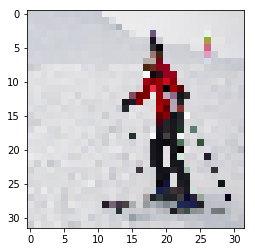

In [223]:
image_idx=5

test_x = [[-1]*(max_len+1)]*batch_size
for i in range(max_len+1):  
    t = sess.run(prediction, feed_dict={x_sentences : test_x, x_image:images}) # 여기서 새 이미지를 batch_size만큼 묶어서 넣으면됨 .
    test_x[image_idx][i] = t[image_idx][i]
    #print(test_x[image_idx]) # 이전단어로 하나씩 인풋을 업그레이드 해나가는 것을 확인할 수 있다.
    print(idx_to_ch[t[image_idx][i]], end=' ')
imshow(images[image_idx])
plt.show()